<a href="https://colab.research.google.com/github/AlrikF/Animation/blob/master/TryMaskRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls
%cd drive/My\ Drive/Colab\ Notebooks/Mask_RCNN_try
!ls

drive  sample_data
/content/drive/My Drive/Colab Notebooks/Mask_RCNN_try
assets		 MANIFEST.in		       requirements.txt
build		 mask_rcnn_coco.h5	       samples
dist		 maskrcnn_config20200515T0759  setup.cfg
images		 mask_rcnn.egg-info	       setup.py
kangaroo-master  mrcnn			       Untitled2.ipynb
LICENSE		 README.md		       Untitled.ipynb


In [0]:
# !ls

In [0]:

# !python3 setup.py install

In [5]:
!pip install keras==2.2.4
%tensorflow_version 1.x
import tensorflow as tf 
#tf.enable_execution()
import keras
print(keras.__version__)

from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree

TensorFlow 1.x selected.


Using TensorFlow backend.


2.2.4


In [0]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 1+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    
    # Learning rate
    LEARNING_RATE=0.006
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

In [0]:
config = myMaskRCNNConfig()

In [8]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "kangaroo")
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(images_dir):
            
            # extract image id
            image_id = filename[:-4]
            
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 150:
                continue
            
            # setting image file
            img_path = images_dir + filename
            
            # setting annotations file
            ann_path = annotations_dir + image_id + '.xml'
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

            # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
            
            # load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')
    # load an image reference
    """Return the path of the image."""
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [10]:
import os
os.listdir("./kangaroo-master/images/")




# prepare train set
train_set = KangarooDataset()
train_set.load_dataset("./kangaroo-master", is_train=True)
train_set.prepare()
print("Train: %d" % len(train_set.image_ids))
# prepare test/val set
test_set = KangarooDataset()
test_set.load_dataset("./kangaroo-master", is_train=False)
test_set.prepare()
print("Test: %d" % len(test_set.image_ids))

Train: 131
Test: 32


In [11]:
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')



Loading Mask R-CNN model...






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [12]:
#load the weights for COCO
model.load_weights('./mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [13]:
## train heads with higher lr to speedup the learning
model.train(train_set, test_set, learning_rate=2*config.LEARNING_RATE, epochs=5, layers="heads")
history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: ./maskrcnn_config20200515T0858/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/5
131/131 [==============================] - 224s 2s/step - loss: 1.8873 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.9846 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.4889 - mrcnn_mask_loss: 0.3090 - val_loss: 2.0540 - val_rpn_class_loss: 0.0362 - val_rpn_bbox_loss: 0.9763 - val_mrcnn_class_loss: 0.0596 - val_mrcnn_bbox_loss: 0.7162 - val_mrcnn_mask_loss: 0.2656

Epoch 2/5
131/131 [==============================] - 179s 1s/step - loss: 1.2055 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.5427 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.3091 - mrcnn_mask_loss: 0.2544 - val_loss: 2.0992 - val_rpn_class_loss: 0.0665 - val_rpn_bbox_loss: 1.3762 - val_mrcnn_class_loss: 0.0547 - val_mrcnn_bbox_loss: 0.3050 - val_mrcnn_mask_loss: 0.2969
Epoch 3/5
131/131 [==============================] - 178s 1s/step - loss: 1.4166 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.7912 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.2765 - mrcnn_mask_loss: 0.2586 - val_loss: 1.7254 - val_rpn_class_l

In [0]:
import time
model_path = './kangaroo-master/mask_rcnn_'  + '.' + str(time.time()) + '.h5'
model.keras_model.save_weights(model_path)

In [15]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
# loading the trained weights o the custom dataset
model.load_weights(model_path, by_name=True)
img = load_img("./kangaroo-master/images/00030.jpg")
img = img_to_array(img)
# detecting objects in the image
result= model.detect([img])



Instructions for updating:
Use `tf.cast` instead.


{'id': '00181', 'source': 'dataset', 'path': './kangaroo-master/images/00181.jpg', 'annotation': './kangaroo-master/annots/00181.xml'}
image ID: dataset.00181 (30) ./kangaroo-master/images/00181.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


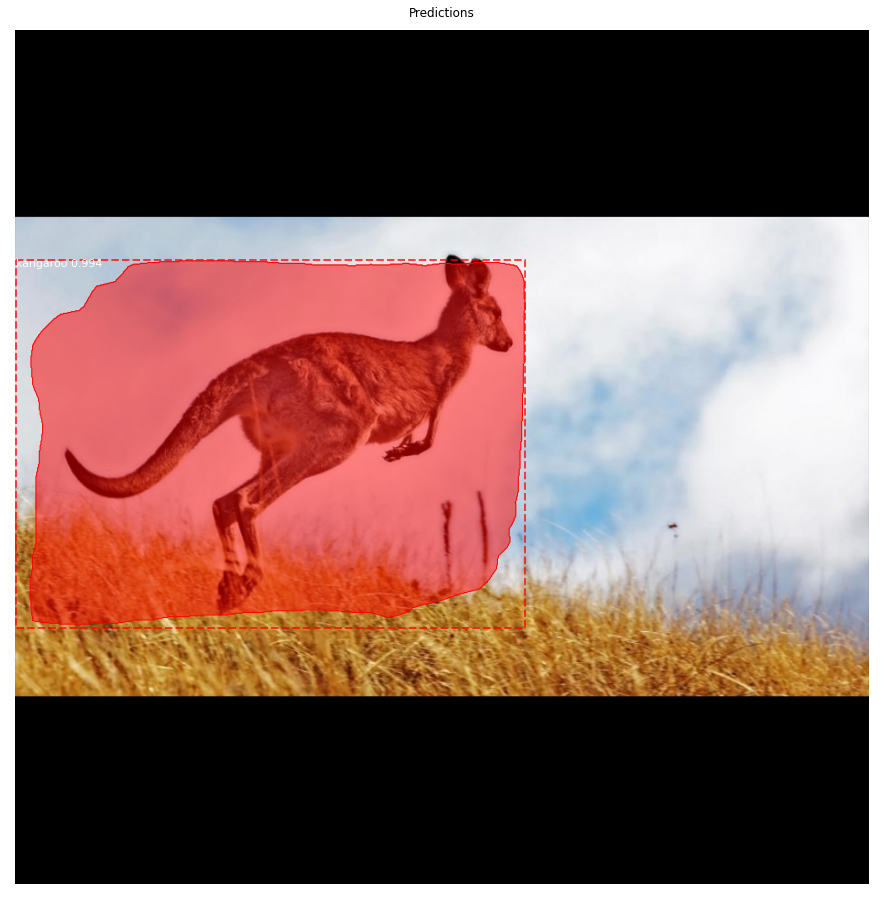

In [16]:
image_id = 30
image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(test_set, config, image_id, use_mini_mask=False)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
# Display results

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], 
                            title="Predictions")